# Classification with South Park Dialogue

Taylor Willingham<br>
September 2019
<img src="images/sp_logo.png" alt="South Park sign" width="150"/>

### Introduction

This project combines Natural Language Processing and classification to predict characters when given a line of dialogue. Specifically, the focus here is to test whether or not a line of dialogue belongs to Cartman. He has the most lines by far and, from simply an anecdotal perspective, has the most distinctive delivery. The main steps were to create the word corpus and preprocess the text -- including remove punctuation, expand contractions, lemmatize the words -- convert the lines of dialogue to vectors with CountVectorizer or TfidfVectorizer, and, finally, use those vectors to train various models in an attempt to find the best one. The algorithms used include <b>Logistic Regression</b>, <b>SVM</b>, <b>Boosting</b> and others. In the end, while all of the algorithms tested exhibited similar levels of accuracy, between 86% and 87%, I think <b>SVM</b> out-performed the others in terms of prediction and speed. 

<b>Layout</b><br>
This notebook consists of the following sections:
* <b>Overview</b>
* <b>Exploring the Data</b>
* <b>Modeling</b>
* <b>Conclusions</b>
<img src="images/sp_boys_waving.png" alt="South Park boys waving" width="300"/>

## Overview

The general intent for this project is to dive into the methods and techniques of natural language processing to get some experience using machine learning on textual data. In order to do so, I have chosen a data set of scripts broken down line by line from episodes of the television show South Park. With this data, my aim is to train a model that, when given a line of dialogue, will be able to accurately predict whether or not a particular character is speaking.<br>
<br>
Now, let’s be clear: this is more of a fun passion project versus anything substantial. Knowing which South Park character is speaking probably isn’t very important, and if you’re hearing the line for the first time you can probably already see who is delivering the line. However, the techniques used here have infinite potential applications. It boils down to a classification problem, where labels are predicted based on text. This could be used to sort types of documents, categorize articles by subject, seek out examples of plagiarism, and countless other things. Not to equate South Park with Shakespeare, but it’s not all that different from scholars trying to determine whether or not an anonymous piece of literature is from the hand of the great poet and playwright. So, even though this project focuses on a comedy TV show, the potential implications reach much further.

## Exploring the Data

<b>Section Overview</b><br>
This section covers loading and cleaning the data, establishing the word corpus, selecting stop words and using word clouds and other visuals to help get an overview of the textual content.

<b>Load in some basic packages</b><br>
First things first

In [2]:
# Load in the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

<b>Load in the data set</b><br>
Import the data and do some basic cleaning. Detailed explanations can be found in report 1, located in the repository subfolder <a href="https://github.com/twillstw/NLP-with-South-Park/tree/master/reports">here</a>.

In [3]:
lines = pd.read_csv('./data/All-seasons.csv')

# Remove unnecessary data
lines = lines[lines.Season != 'Season']

# Convert some features to the correct data type
lines[['Season', 'Episode']] = lines[['Season', 'Episode']].astype('int64')

With the basic data set loaded and prepped, we can check the shape the first few rows.

In [4]:
lines.shape

(70879, 4)

In [4]:
lines.head(3)

,Season,Episode,Character,Line
0,10,1,Stan,"You guys, you guys! Chef is going away. \n"
1,10,1,Kyle,Going away? For how long?\n
2,10,1,Stan,Forever.\n


As we can see, there are roughly 71,000 lines of dialogue, or documents for the purpose of this project, and only one real feature of importance, which is `Line`. The `Character` column represents the target label.<br>
<br>
For a macro level overview, here is the distribution of lines across seasons:

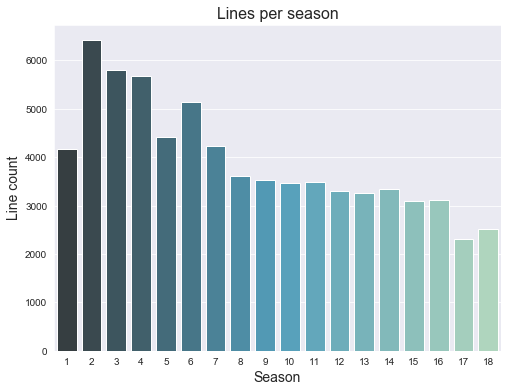

In [5]:
lines_per_season = lines.groupby('Season').count()[['Line']].sort_index()

fig = plt.subplots(figsize=(8,6))
_ = sns.barplot(lines_per_season.index, lines_per_season.Line, palette='GnBu_d')
_ = plt.xlabel('Season', fontsize=14)
_ = plt.ylabel('Line count', fontsize=14)
_ = plt.title('Lines per season', fontsize=16)

Clearly there are more lines in the first few seasons, the main reason likely being that later seasons have fewer episodes. It's not clear if this really matters, but if there are general overarching changes in the show vocabulary as a whole then that means that the data may be biased towards the earlier seasons. That might be difficult to quantify, but it could have a subtle effect on the results.


<b>Character distribution</b><br>
The next important thing to examine is the number of characters represented in the data, or how many classes we are dealing with, and also how many lines of dialogue are associated with each character. I used a `Counter` object for these tasks.

In [6]:
from collections import Counter

character_count = Counter(lines.Character)
len(character_count)

3949

In [7]:
character_count.most_common(15)

[('Cartman', 9774),
 ('Stan', 7680),
 ('Kyle', 7099),
 ('Butters', 2602),
 ('Randy', 2467),
 ('Mr. Garrison', 1002),
 ('Chef', 917),
 ('Kenny', 881),
 ('Sharon', 862),
 ('Mr. Mackey', 633),
 ('Gerald', 626),
 ('Jimmy', 597),
 ('Wendy', 585),
 ('Liane', 582),
 ('Sheila', 566)]

To visualize these distributions we can generate a bar plot:

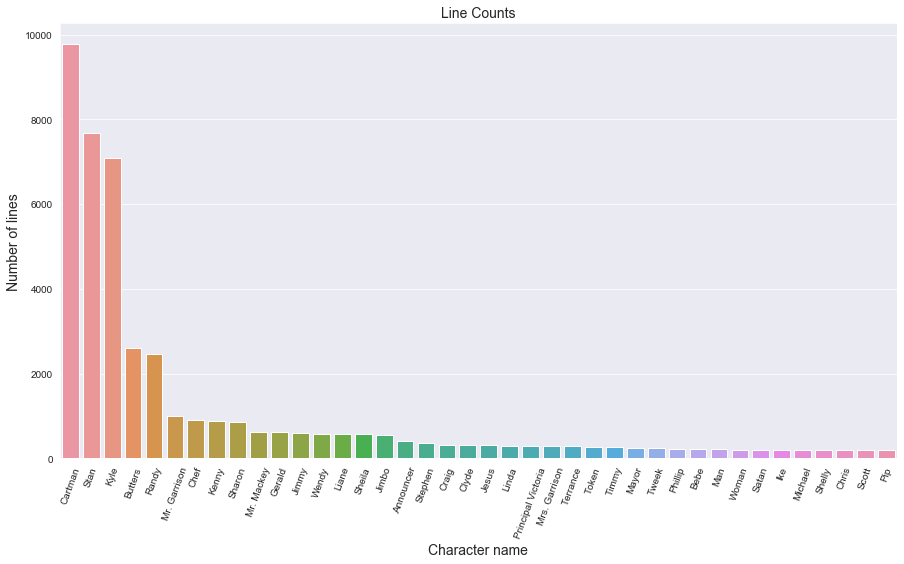

In [8]:
names = [tup[0] for tup in character_count.most_common(40)]
counts = [tup[1] for tup in character_count.most_common(40)]

fig = plt.subplots(figsize=(15,8))
_ = sns.barplot(names, counts)
_ = plt.xlabel('Character name', fontsize=14)
_ = plt.ylabel('Number of lines', fontsize=14)
_ = plt.title('Line Counts', fontsize=14)
_ = plt.xticks(rotation=70)

In total, there are nearly 4,000 (!!) characters. This makes sense given that South Park, like any show, has many temporary and minor characters. However, this is way too many labels to deal with, so a decision needs to be made. We can focus on a particular subset of characters and disregard the rest, we can group characters based on certain criteria, like primary versus secondary characters, or we can compare one character to the others make it a binary classification problem.<br>
<br>
I chose the last approach, comparing Cartman to the rest of the characters. We can see above that he has the most lines of dialogue, and one could easily make an argument that he is the primary character. Another benefit of doing it this way is that we don't have to discard any of the data. This will create a class imbalance, but we can deal with that later if it presents a problem.

With the decision made, the data set needs to be adjusted by adding a column to represent the target label.

In [9]:
lines['is_cartman'] = 0

lines.loc[lines.Character == 'Cartman', 'is_cartman'] = 1

lines.head(3)

,Season,Episode,Character,Line,is_cartman
0,10,1,Stan,"You guys, you guys! Chef is going away. \n",0
1,10,1,Kyle,Going away? For how long?\n,0
2,10,1,Stan,Forever.\n,0


### Word Corpus and Vocab Preprocesing

Now that we have extracted the data of interest, it needs to be preprocessed to get it into a format more suitable for machine learning. Here is a sample of what we're starting with:

In [10]:
lines.iloc[4:9]

,Season,Episode,Character,Line,is_cartman
4,10,1,Stan,"Chef said he's been bored, so he joining a gro...",0
5,10,1,Chef,Wow!\n,0
6,10,1,Mrs. Garrison,Chef?? What kind of questions do you think adv...,0
7,10,1,Chef,What's the meaning of life? Why are we here?\n,0
8,10,1,Mrs. Garrison,I hope you're making the right choice.\n,0


And here are the general steps I followed in order to get to the final word corpus:
* Compile all strings, or lines of dialogue into one list
* Remove the new-line figure (`\n`) from each line
* Convert each word to lowercase and remove punctuation
* Expand all contractions to their whole words
* Lemmatize all nouns and verbs so that only root words are present  
<br>
<br>
For more insight, refer to Notebook 2 in the <a href="https://github.com/twillstw/NLP-with-South-Park/tree/master/reports">reports</a> subfolder.

In [11]:
import re, string
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import contractions

corpus = lines.Line.tolist()

for line in range(len(corpus)):
    corpus[line] = re.sub('\\n', '', corpus[line].rstrip()).lower()
    corpus[line] = " ".join(word.strip(string.punctuation) for word in corpus[line].split())
    
corpus[4:9]

["chef said he's been bored so he joining a group called the super adventure club",
 'wow',
 'chef what kind of questions do you think adventuring around the world is gonna answer',
 "what's the meaning of life why are we here",
 "i hope you're making the right choice"]

Above, we can see that the new-line figure is removed, all letters are lowercase and the punctuation is removed. Next, contractions are expanded.

In [12]:
for line in range(len(corpus)):
    corpus[line] = contractions.fix(corpus[line])
                                  
corpus[4:9]

['chef said he is been bored so he joining a group called the super adventure club',
 'wow',
 'chef what kind of questions do you think adventuring around the world is going to answer',
 'what is the meaning of life why are we here',
 'i hope you are making the right choice']

And finally, the words are lemmatized.

In [13]:
lem = WordNetLemmatizer()

def lemmatize_lines(line):
    '''function to lemmatize the corpus
    line by line'''
    word_list = word_tokenize(line)
    
    word_list = [lem.lemmatize(w, pos='v') for w in word_list]
    
    lem_line = ' '.join([lem.lemmatize(w) for w in word_list])
    
    return lem_line

In [14]:
for line in range(len(corpus)):
    corpus[line] = lemmatize_lines(corpus[line])
    
corpus[4:9]

['chef say he be be bore so he join a group call the super adventure club',
 'wow',
 'chef what kind of question do you think adventure around the world be go to answer',
 'what be the mean of life why be we here',
 'i hope you be make the right choice']

<img src="images/chef.png" alt="Chef waving" width="140"/>

### Word Frequencies and Stop Words

With the corpus cleaned, we can now calculate which words occur most frequently and search for potential stop words. To do this, I used a `Counter` and an `OrderedDict` to order words by their total frequencies. I then created two functions to compare the words individually to confirm whether or not they should be treated as stop words. In essence, words that are not evenly distributed across all classes but tend to distinguish one or two classes from the others have more significance and should not be treated as stop words. This is similar to the concept utilized by tf-idf, which is implemented later. 

In [15]:
words = " ".join(corpus)

from collections import Counter, OrderedDict

word_counts = Counter(words.split())

token_dict = OrderedDict(word_counts.most_common())

# An abridged list of the most common words
[(k, v) for k, v in token_dict.items()][:10]

[('be', 50399),
 ('you', 29087),
 ('the', 25182),
 ('to', 23957),
 ('i', 17767),
 ('a', 16796),
 ('it', 14770),
 ('do', 14593),
 ('not', 14323),
 ('and', 13407)]

In [16]:
def freq_compare(word, corpus=corpus):
    '''Takes a word and a word corpus and calculates
    the total word frequency and the number of documents
    containing that word.'''
    
    word = word.lower()
    
    words = " ".join(corpus).lower()
    words = " ".join(word.strip(string.punctuation) for word in words.split())
    
    word_counts = Counter(words.split())
    token_dict = OrderedDict(word_counts.most_common())
    
    total_frequency = token_dict[word]
    
    doc_freq = 0
    
    for line in corpus:
        if word in [token.strip(string.punctuation).lower() for token in line.split()]:
            doc_freq += 1
    
    print('The total frequency of the word \'{}\' is: \t'.format(word), total_frequency)
    print('The number of documents with the word \'{}\': \t'.format(word), doc_freq)
    
def compare_labels(term):
    '''Takes a particular word and calculates
    how often it is used by each character'''
    
    term = term.lower()
    
    count_dict = {'Cartman': 0, 'Not Cartman': 0}
    
    for k, v in count_dict.items():
        if k == 'Cartman':
            subset = lines[lines.Character == 'Cartman']
        else:
            subset = lines[lines.Character != 'Cartman']
        
        corpus = subset.Line.tolist()

        for line in range(len(corpus)):
            corpus[line] = re.sub('\\n', '', corpus[line].rstrip())
        
        words = " ".join(corpus).lower()
        words = " ".join(word.strip(string.punctuation) for word in words.split())
    
        word_counts = Counter(words.split())
        token_dict = OrderedDict(word_counts.most_common())
        
        if term in token_dict.keys():
            count_dict[k] += token_dict[term]
        
        # Now convert to a ratio
        count_dict[k] = round((count_dict[k] / len(subset)), 3)
    
    print('How often the word \'{}\' appears in each class:'.format(term))
    print(count_dict)

In [17]:
def word_freqs(word):
    freq_compare(word)
    compare_labels(word)

word_freqs('do')

The total frequency of the word 'do' is: 	 14593
The number of documents with the word 'do': 	 12240
How often the word 'do' appears in each class:
{'Cartman': 0.075, 'Not Cartman': 0.07}


Using the functions and the example word 'do', we can see that the word occurs frequently and is used similarly by both classes. This means it is not very unique and does not convey much information, so it can be treated as a stop word. After comparing several of the most frequent terms, this is list of stop words that I compiled. I chose to keep 'my' and 'me' because they had slightly imbalanced distributions, which might owe to Cartman's selfish nature. I also chose to keep 'no' and 'not' because those might be useful later when moving beyond a simple bag-of-words model.

In [18]:
sw = ['be', 'you', 'i', 'to', 'the', 'do', 'it',\
        'a', 'we', 'that', 'and', 'have', 'go', 'what',\
        'get', 'of', 'this', 'in', 'on', 'all', 'just',\
        'for', 'he', 'know', 'will', 'but', 'with', 'so',\
        'they', 'now', 'well', "'s", 'guy', 'u', 'come',\
        'like', 'there', 'at', 'would', 'who', 'him',\
        'them', 'his', 'thing', 'where', 'should', 'an',\
        'please', 'maybe', 'their', 'even', 'any', 'than']

### Word Clouds

Beyond simple line counts, word clouds are a useful way to visualize word frequencies. This can be helpful to see how certain characters might favor certain words, illustrating differences in dialogue. I also updated the stopword list for the purpose of visualization. See notebook 3 in the reports subfolder for more examples, but below is a function to create character-specific word clouds along with a few examples.

In [19]:
viz_sw = sw.copy()
add_sw = ['on', 'no', 'not', 'now', 'yeah', 'not', 'well', 'your', \
          'hey', 'really', 'could', 'would', 'doing', 'good', 'way']
viz_sw.extend(add_sw)

In [20]:
from wordcloud import WordCloud
font_path = './data/CabinCondensed-Medium.ttf'

def character_cloud(character):
    
    subset = lines[lines.Character == character]
    
    sub_corp = subset.Line.tolist()
    for line in range(len(sub_corp)):
        sub_corp[line] = re.sub('\\n', '', sub_corp[line].rstrip())
        sub_corp[line] = sub_corp[line].lower()
        sub_corp[line] = " ".join(word.strip(string.punctuation) for word in sub_corp[line].split())
        sub_corp[line] = contractions.fix(sub_corp[line])
        sub_corp[line] = lemmatize_lines(sub_corp[line])
        
    char_cloud = WordCloud(stopwords=viz_sw,\
                           font_path=font_path,\
                           random_state=2,\
                           normalize_plurals=False,\
                           background_color='#ddf2eb').generate(str(sub_corp))
    
    fig = plt.subplots(figsize=(11,8))
    _ = plt.imshow(char_cloud, interpolation='bilinear')
    _ = plt.axis('off')
    _ = plt.title(character, fontsize=26)

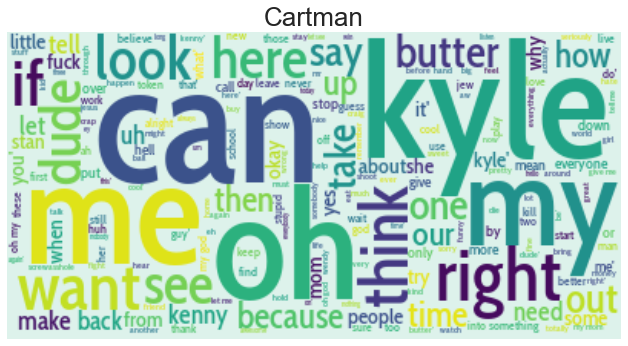

In [56]:
character_cloud('Cartman')

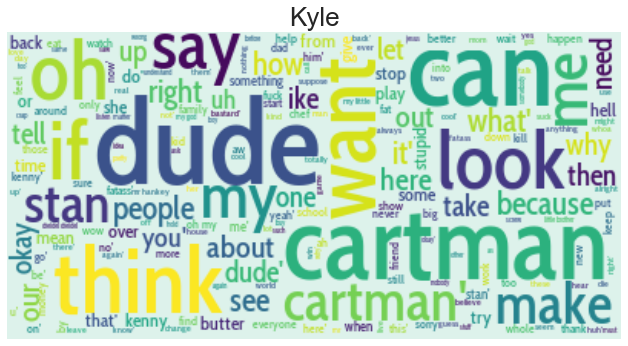

In [57]:
character_cloud('Kyle')

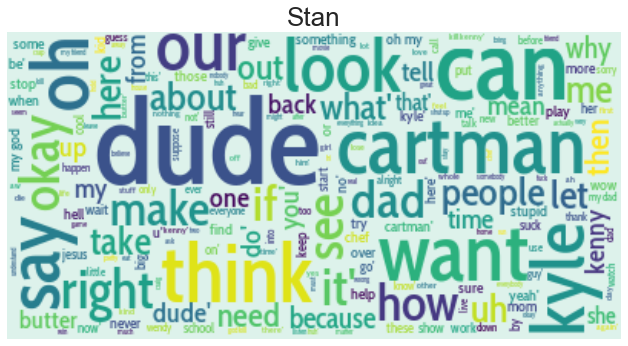

In [58]:
character_cloud('Stan')

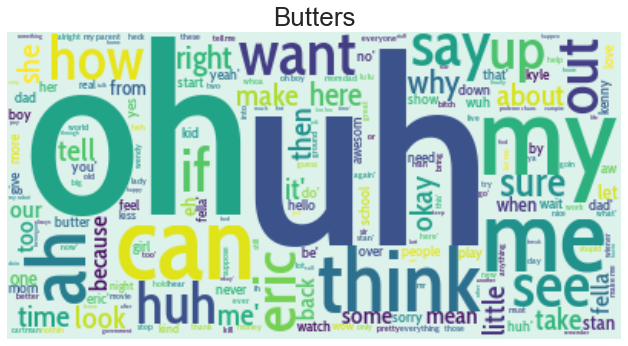

In [59]:
character_cloud('Butters')

The similarity between the word clouds for Stan and Kyle is striking, while Cartman seems to really favor 'me' and 'my' comparative to the others.

## Modeling

The word corpus has been prepared, and now it's time to try and find the model that makes the most accurate prediction. Before a model can be trained though, the word corpus needs to be converted into mathematical vectors. To achieve this, I used `CountVectorizer` and `TfidfVectorizer` from Scikit Learn. Once the vectorized dictionary was established, I split the data into test and training sets in order to train a model. With each of the different vector types I first started with a Multinomial Naive Bayes algorithm. From there, I also used the tf-idf vector to train other models using Random Forest, SVM, Logistic Regression and variants of Boosting. The accuracy levels did not vary much between the models, but the confusion matrices varied quite a bit. A full table comparing the results can be found in the final section.

<b>Establishing the CountVectorizer</b><br>
This is essentially a bag of words, where documents are assessed based on how many times each word appears. Also of note is the `ngram_range` parameter, which accounts for unigrams, bigrams and so on. I tested for several ranges, but the range of (1,3) yielded the best results with CountVectorizer. See notebook 4 in the reports subfolder for more details.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [31]:
vectorizer = CountVectorizer(stop_words=sw, ngram_range=(1,3))

X = vectorizer.fit_transform(corpus)
y = lines.is_cartman

state = 3

# How many features are there?
X.shape[1]

536629

<b>Splitting the data and training Multinomial Naive Bayes</b><br>
Now the features, X, and the target labels, y, need to be split into test and training sets. Then we can fit the data to a Multinomial Naive Bayes model and cross validate on the training data before checking against the test data.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=state)

In [22]:
%%time

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

mnb = MultinomialNB()

cv_scores = cross_val_score(mnb, X_train, y_train, cv=5)

Wall time: 292 ms


In [23]:
print('Scores: ', cv_scores)
print('Average score: ', np.mean(cv_scores))

Scores:  [0.86255542 0.86174929 0.86213847 0.86242693 0.8612175 ]
Average score:  0.8620175217113915


The results right out of the box are decent.<br>
<br>
<b>Various N-grams</b><br>
Here are the out-of-the-box results for different n-gram ranges:

| ngram_range | Number of features | Mean cv score        |
|-------------|--------------------|----------------------|
|  (1,1)      | 20,939             | 0.856                 |
| (1,2)       | 232,654            | 0.860                 |
| (1,3)       | 536,629            | 0.862                 |
| (1,5)       | 1,060,181          | 0.849                 |
| (2,2)       | 211,715            | 0.812                 |
| (3,3)       | 303,975            | 0.720                 |

Experimenting further with hyper-tuning for values of *alpha* for `MultinomialNB` only yields a slight improvement.

In [24]:
from sklearn.model_selection import GridSearchCV

params = {'alpha': [1.1, 1.15, 1.17, 1.2, 1.25, 1.3]}

nb_grid = GridSearchCV(mnb, params, cv=5)

nb_grid.fit(X_train, y_train)

print('Best alpha: ', nb_grid.best_estimator_)
print('Best score: ', nb_grid.best_score_)

Best alpha:  MultinomialNB(alpha=1.15, class_prior=None, fit_prior=True)
Best score:  0.8629849843797238


In [25]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_train, nb_grid.predict(X_train)))

[[42748    25]
 [ 3365  3477]]


Now to check it against the test data:

In [26]:
pred = nb_grid.predict(X_test)
print(accuracy_score(y_test, pred))

0.8593397291196389


In [27]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, pred)

array([[17953,   379],
       [ 2612,   320]], dtype=int64)

For this particular model, the accuracy score is more or less the same for both the training data and the test data. However, the confusion matrix shows that it doesn't predict the minority class, or the Cartman lines, very well. 

<b>Common phrases</b><br>
We can also use the CountVectorizer along with different n-gram ranges to find common phrases used by Cartman. By using different ranges we can examine phrases of differing lengths. See notebook 4 for a detailed explanation.

In [30]:
ind = list(y[y ==1].index)

vocab_values = []
    
for i in ind:
    vec = X[i].toarray().tolist()
    vec = vec[0]
    for i, el in enumerate(vec):
        if el > 0:
            vocab_values.append(i)
            
vocab = vectorizer.vocabulary_

new_vocab = dict([(v, k) for k, v in vocab.items()])

vocab_words = []
for i in vocab_values:
    word = new_vocab[i]
    vocab_words.append(word)
    
from collections import Counter

cartman_phrases = Counter(vocab_words)
cartman_phrases.most_common(10)

[('not', 1852),
 ('my', 756),
 ('can', 707),
 ('me', 703),
 ('oh', 683),
 ('your', 647),
 ('no', 540),
 ('yeah', 506),
 ('here', 468),
 ('right', 462)]

<b>Most common words and phrases for Cartman</b><br>
<br>

| Single words\: (1,1)        | Two word phrases\: (2,2)| Three word phrases\: (3,3)|
|-----------------------------|-------------------------|---------------------------|
| not                         |  can not                |  oh my god                |
| my                          |  my got                 | can not believe           |
| can                         |  oh my                  | not tell me               |
| me                          |  not want               | no no no                  |
| oh                          |  not think              | can not wait              |
| your                        | south park              | can not let               |
| no                          | no not                  | let me see                |
| yeah                        | why not                 | dude can not              |
| here                        | tell me                 | no can not                |
| right                       | no no                   | why can not               |

The entries in the table above aren't as distinct as I had hoped. All the negative words kind of get in the way but, on the other hand, it shows how central the negations are to the tone of the dialogue. The sentiment of these phrases would be much different if 'no' and 'not' were removed from the corpus. Also, the expanded contractions and other preprocessing techniques kind of dilute the phrases.

### Tf-idf

To try and make further improvements, we can use a weighted tf-idf vectorizer instead of a basic CountVectorizer. Stop words aren't as big of a concern here due to the inherent adjustments, but since we already have a list we may as well use it. I again tried different n-grams for the new vectorizer, but (1,1) proved best in this scenario. Also, because this is a new vectorizer we will have to create new train and test splits.

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vect = TfidfVectorizer(stop_words=sw, ngram_range=(1,1))

X = tf_vect.fit_transform(corpus)
y = lines.is_cartman

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=11)

Now to run the new splits with MultinomialNB and check the scores.

In [32]:
%%time
params = {'alpha': [1.0, 1.25, 1.35, 1.4]}

t_nb_grid = GridSearchCV(mnb, params, cv=5)

t_nb_grid.fit(X_train, y_train)

print('Best alpha: ', t_nb_grid.best_estimator_)
print('Best score: ', t_nb_grid.best_score_)

Best alpha:  MultinomialNB(alpha=1.25, class_prior=None, fit_prior=True)
Best score:  0.8621989317746649
Wall time: 294 ms


In [33]:
print(confusion_matrix(y_train, t_nb_grid.predict(X_train)))
print(classification_report(y_train, t_nb_grid.predict(X_train), np.unique(y)))

[[42766     7]
 [ 6728   114]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.93     42773
           1       0.94      0.02      0.03      6842

    accuracy                           0.86     49615
   macro avg       0.90      0.51      0.48     49615
weighted avg       0.87      0.86      0.80     49615



Combined with MultinomialNB, the tf-idf vectorizer has about the same accuracy compared to CountVectorizer, but the confusion matrix shows a significant decrease in the predictive ability. The precision for Cartman predictions is high, but recall is terrible, lowering the f1 score to 0.03. However, there may be other algorithms better suited to the weighted vectors.

### Trying other models <br>
Since MultinomialNB had its faults, I did try a few other algorithms in the hopes of making an improvement. <br>
<br>
<b>Random Forest</b><br>
First, let's try Random Forest, still with the tf-idf vectors. With oob_score (out of bag) set to 'True', we use the out-of-bag samples as a sort of validation set. I also tried setting `class_weight` to 'balanced' to try to account for the class imbalance. This lowers the accuracy, but improves the other metrics.

In [34]:
%%time
# first without class weights
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100,\
                            max_features='sqrt',\
                            oob_score=True,\
                            random_state=state,\
                            n_jobs=-1)

rf.fit(X_train, y_train)
print(rf.oob_score_)

0.8624811045046861
Wall time: 1min 36s


In [35]:
confusion_matrix(y_train, rf.predict(X_train))

array([[42702,    71],
       [  928,  5914]], dtype=int64)

In [36]:
confusion_matrix(y_test, rf.predict(X_test))

array([[18063,   269],
       [ 2656,   276]], dtype=int64)

Using the training the data, the results look great, but it's a different story when validating the results. The recall is awful. To try and get more consistent results, we can play with some parameters and balance the classes.

In [100]:
rf_bal = RandomForestClassifier(n_estimators=400,\
                            max_features='sqrt',\
                            class_weight='balanced',\
                            max_depth=5,\
                            oob_score=True,\
                            random_state=state,\
                            n_jobs=-1)

rf_bal.fit(X_train, y_train)
print(rf_bal.oob_score_)

0.766945480197521


In [101]:
print(confusion_matrix(y_train, rf_bal.predict(X_train)))
print(classification_report(y_train, rf_bal.predict(X_train), np.unique(y)))

[[35136  7637]
 [ 3297  3545]]
              precision    recall  f1-score   support

           0       0.91      0.82      0.87     42773
           1       0.32      0.52      0.39      6842

    accuracy                           0.78     49615
   macro avg       0.62      0.67      0.63     49615
weighted avg       0.83      0.78      0.80     49615



In [103]:
print(confusion_matrix(y_test, rf_bal.predict(X_test)))
print(classification_report(y_test, rf_bal.predict(X_test), np.unique(y)))

[[14904  3428]
 [ 1542  1390]]
              precision    recall  f1-score   support

           0       0.91      0.81      0.86     18332
           1       0.29      0.47      0.36      2932

    accuracy                           0.77     21264
   macro avg       0.60      0.64      0.61     21264
weighted avg       0.82      0.77      0.79     21264



The accuracy takes a hit, but the recall is better.<br>
<br>
<b>SVM</b><br>
We can also try Support Vector Machines.

In [105]:
%%time
from sklearn.svm import LinearSVC

svm = LinearSVC(max_iter=5000, class_weight={0: 0.4, 1: 2}, random_state=3)

params = {'C': [0.5]}

sv_grid = GridSearchCV(svm, params, cv=5)

sv_grid.fit(X_train, y_train)

print('Best C: ', sv_grid.best_estimator_)
print('Best score: ', sv_grid.best_score_)

Best C:  LinearSVC(C=0.5, class_weight={0: 0.4, 1: 2}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=5000,
          multi_class='ovr', penalty='l2', random_state=3, tol=0.0001,
          verbose=0)
Best score:  0.7860727602539554
Wall time: 1.1 s


In [106]:
confusion_matrix(y_train, sv_grid.predict(X_train))

array([[36893,  5880],
       [ 1748,  5094]], dtype=int64)

Now to validate:

In [107]:
confusion_matrix(y_test, sv_grid.predict(X_test))

array([[15342,  2990],
       [ 1520,  1412]], dtype=int64)

In [108]:
print(classification_report(y_test, sv_grid.predict(X_test), np.unique(y)))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87     18332
           1       0.32      0.48      0.39      2932

    accuracy                           0.79     21264
   macro avg       0.62      0.66      0.63     21264
weighted avg       0.83      0.79      0.80     21264



A similar observation as before where the accuracy is similar, but there is a significant change in the confusion matrix results. The results are slightly better than Random Forest.<br>
<br>
It's not shown here, but I also ran Logistic Regression, and the results are included in the table below.

<b>Boosting</b><br>
<br>
In addition to the previous models, I also tried different boosting algorithms to see if learning sequentially would help. I tried both Gradient Boost and AdaBoost, but AdaBoost seemed to perform better. See report 4 for more details.

In [115]:
%%time
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=1, class_weight='balanced', random_state=state)

adb = AdaBoostClassifier(base_estimator=dt, n_estimators=200)

_ = adb.fit(X_train, y_train)

Wall time: 2min 30s


In [117]:
print('Score: ', accuracy_score(y_train, adb.predict(X_train)))

Score:  0.7609392320870705


In [118]:
confusion_matrix(y_train, adb.predict(X_train))

array([[33882,  8891],
       [ 2970,  3872]], dtype=int64)

And now to validate:

In [121]:
print(confusion_matrix(y_test, adb.predict(X_test)))
print(classification_report(y_test, adb.predict(X_test), np.unique(y)))

[[14358  3974]
 [ 1438  1494]]
              precision    recall  f1-score   support

           0       0.91      0.78      0.84     18332
           1       0.27      0.51      0.36      2932

    accuracy                           0.75     21264
   macro avg       0.59      0.65      0.60     21264
weighted avg       0.82      0.75      0.77     21264



The boosting results didn't exactly blow the others out of the water, and the  computational expense really devalues the results. I think it's clear to see that of all the algorithms tried, SVM performed the best. It's light and fast, and the results met or far exceeded the results from any of the other algorithms.<br>
<br>
I must say, I am a bit bummed that none of the models performed better. It would be nice to see accuracy in the 90% range, and see a little less conflict between the precision and recall. As it stands, it's kind of a case of pick your poison. Some are more accurate while some are better at predicting Cartman's lines. In my judgement, SVM strikes the best balance. As for why we struggled to get ideal results and what to do next, I offer thoughts on that below in the conclusions.<br>
<br>
<img src="images/sad_butters.png" alt="Chef waving" width="300"/>

## Conclusions

We managed to take the data set of dialogue, clean it up and preprocess it, and use it to create vocab vectors. The accuracy scores were pretty good, but the confusion matrices revealed some issues, likely due to the imbalance in data. In any case, for the sake of comparison, below is a breakdown of the results. 

#### Overall Results
| Algorithm                               | Accuracy  | Target F1 Score |Runtime    | 
|-----------------------------------------|-----------|-----------------|-----------|
| MultinomialNB - with CountVectorizer    | 0.863     | 0.18            | 527 ms    |
| MultinomialNB - with TfidfVectorizer    | 0.862     | 0.03            | 246 ms    |
| Random Forest (balanced weights)        | 0.767     | 0.36            | 1 min 17 s|
| SVM (adjusted weights)                  | 0.786     | 0.39            | 1.1 s     |
| Logistic Regression                     | 0.867     | 0.21            | 24 s      |
| Gradient Boost                          | 0.866     | 0.06            | 1 min 48 s|
| AdaBoost                                | 0.761     | 0.36            | 2 min 30 s|

<b>Closing Thoughts</b><br>
Despite the results, on a macro level, I think it was beneficial to see the potential of these techniques and get a grasp of the NLP pipeline. As for why the models weren't successful, I think it likely has to do with the source of the data, the way it is structured and the approach to the problem.<br>
<br>
In regards to the source, we have to keep in mind that South Park is essentially created by only two people, Trey Parker and Matt Stone. So even though we have multiple characters, many of those characters likely have the same person behind them crafting the dialogue and delivering the voice-overs. This means that some of the boundaries of distinction between characters might get blurred, making classification difficult.<br>
<br>
The other thing to consider is the structure of the documents. We are dealing with lines of dialogue, which can often be very short, many times only consisting of one or two words. If a character responds to a question with a simple "yes" or "no", that one word answer would still be considered as an entire document. Trying to classify such a document would be little more than guesswork. It's likely this was a contributing factor to the low levels of recall.<br>
<br>
To address the issue of document length we could drop all lines below a certain threshold. That might cut down on the total number of observations, but it might help ensure there is enough information within each vector. On the other hand, we might lose certain catch phrases that may be short but could still help identify a certain character. It seems like there are tradeoffs for any approach we might choose.<br>
<br>
To try and improve the results, there are a few next steps we might attempt:
* Test thresholds for document length
* Omit some of the preprocessing steps -- maybe contractions are used differently by certain characters
* Use a more complex model such as deep learning
* Narrow the focus by omitting unimportant characters that might dilute the data<br>
<br>
Then again, maybe the answer is to just use the Simpsons for our data set: a show with so many seasons that there's bound to be enough data to solve our problems. 